In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import numpy as np
import os

%pylab inline

image_width=20

pwd = os.getcwd()
tfrecord_file_path = pwd + "/AE_input_sand_ch1_20.tfrecord"
filename_queue = tf.train.string_input_producer(
                              tf.train.match_filenames_once(tfrecord_file_path),
                              shuffle=True, num_epochs=None)

reader = tf.TFRecordReader()
_, serialized_example = reader.read(filename_queue)
features = tf.parse_single_example(serialized_example,
                                       features={'data': tf.FixedLenFeature([], tf.string)}) 
img = tf.decode_raw(features['data'], tf.uint8)
img = tf.image.convert_image_dtype(img,tf.float32)
img = tf.reshape(img, [image_width * image_width])
input_batch = tf.train.shuffle_batch([img],batch_size=50,capacity=500,min_after_dequeue=250,num_threads=4)

# Training Parameters
learning_rate = 0.001
num_steps = 50000
display_step = 1000
#learning_rate = tf.train.exponential_decay(0.001,num_steps,display_step,decay_rate=0.98,staircase=True)  

# Network Parameters
num_hidden_1 = 500 # 1st layer num features
num_input = image_width * image_width

X = tf.placeholder("float", [None, num_input],name='input_x')

encoder_h1=tf.Variable(tf.random_normal([num_input, num_hidden_1]))
decoder_h1=tf.transpose(encoder_h1)

biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b1': tf.Variable(tf.random_normal([num_input])),
}

# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, encoder_h1),
                                   biases['encoder_b1']))
    return layer_1


# Building the decoder
def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, decoder_h1),
                                   biases['decoder_b1']))
    return layer_1

def cosine(a,b):
    a_norm = tf.sqrt(tf.reduce_sum(tf.pow(a,2)))
    b_norm = tf.sqrt(tf.reduce_sum(tf.pow(b,2)))
    a_b = tf.reduce_sum(tf.multiply(a,b))
    cosin = tf.divide(a_b,tf.multiply(a_norm,b_norm))
    return cosin

def kl_divergence(p, h): #对所有x的每个h取平均作为phat，最终所有h相加求和
    p_hat = tf.reduce_mean(h,axis=0)
    #p_hat = h
    return tf.reduce_sum(p * tf.log(p)
                            - p * tf.log(tf.clip_by_value(p_hat, 1e-8, tf.reduce_max(p_hat)))
                            + (1 - p) * tf.log(1-p)
                            - (1 - p) * tf.log(tf.clip_by_value(1-p_hat, 1e-8, tf.reduce_max(1-p_hat))))

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error

#loss = tf.reduce_sum(tf.pow(y_true - y_pred, 2))
sparsity_level = 0.05
loss = tf.reduce_sum(tf.pow(tf.subtract(y_true, y_pred), 2.0))+10 * kl_divergence(sparsity_level, encoder_op)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

#loss = tf.reduce_sum(tf.subtract(tf.constant(1.0),cosine(y_true,y_pred)))
#optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

saver = tf.train.Saver()
tf.add_to_collection('output_y', encoder_op)
tf.add_to_collection('output_y', decoder_op)
#tf.add_to_collection('output_y', loss)

with tf.Session() as sess:
    
    tf.local_variables_initializer().run()
    tf.global_variables_initializer().run()
    coord = tf.train.Coordinator()
    thread = tf.train.start_queue_runners(sess=sess,coord=coord)
    
    saver = tf.train.import_meta_graph('saver/SAE2/SAE.meta')
    saver.restore(sess,'saver/SAE2/SAE') 
    
    result = []
    for i in range(1,num_steps+1):
        _, l, h = sess.run([optimizer, loss, encoder_op],feed_dict={X: input_batch.eval()})
        result.append(l)
        if i % display_step == 0 or i == 1:
            print('Step %i: Minibatch Loss: %f' % (i, l))
            
    saver.save(sess,'saver/SAE2/SAE')
    
    coord.request_stop()
    coord.join(thread)

Populating the interactive namespace from numpy and matplotlib
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Restoring parameters from saver/SAE2/SAE
Step 1: Minibatch Loss: 35.559551
Step 1000: Minibatch Loss: 34.722111
Step 2000: Minibatch Loss: 35.955997
Step 3000: Minibatch Loss: 38.407070
Step 4000: Minibatch Loss: 36.959301
Step 5000: Minibatch Loss: 31.413216
Step 6000: Minibatch Loss: 29.122349
Step 7000: Minibatch Loss: 31.249298
Step 8000: Minibatch Loss: 29.635532
Step 9000: Minibatch Loss: 31.963202
Step 10000: Minibatch Loss: 36.592056
Step 11000: Minibatch Loss: 33.612862
Step 12000: Minibatch Loss: 33.031860
Step 13000: Minibatch Loss: 29.150133
Step 14000: Minibatch Loss: 27.335278
Step 15000: Minibatch Loss: 31.285641
Step 16000: Minibatch Loss: 31.67589

(20000, 200000)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


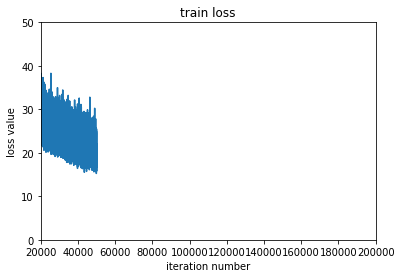

In [2]:
plt.rc('font',family='Times New Roman',size=10)
plt.xlabel("iteration number")
plt.ylabel("loss value")
plt.title("train loss")
plt.plot(result)
plt.ylim(0,50)
plt.xlim(20000,200000)